# Exploratory Data Analysis

In [468]:
!pip install neurokit2


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


---

## Imports

In [469]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import datetime
import xlrd
from tabulate import tabulate
import seaborn as sns
import neurokit2 as nk 
from statsmodels.tsa.stattools import acf, q_stat

In [470]:
data_folder = Path("data") 
all_csv = list(data_folder.glob("*.csv"))

---

## Preprocessing

In [471]:
def icmp_dateformat_to_datetime(icmp_time_mark):
    """
    Convert ICMP time mark to datetime format
    
    Args:
        icmp_time_mark (float): ICMP time mark
    
    Returns:
        datetime_date (datetime): Datetime format of ICMP time mark
    """
    datetime_date = xlrd.xldate_as_datetime(icmp_time_mark, 0)
    datetime_date = datetime_date + datetime.timedelta(hours=1)
    return datetime_date

In [472]:
def time_encoder(df):
  """
  Encode time features from datetime column
  
  Args:
      df (DataFrame): Dataframe to encode time features
      
  Returns:
      df (DataFrame): Dataframe with encoded time features
  """
  df['time'] = pd.to_datetime(df['DateTime'])
  df['hour'] = df['time'].dt.hour
  df['day'] = df['time'].dt.day
  return df

In [473]:
data_frames = {}
for file in tqdm(all_csv):
  df = pd.read_csv(file, sep=";", decimal=",")
  df['DateTime'] = df['DateTime'].apply(icmp_dateformat_to_datetime)
  df = time_encoder(df)  
  df.set_index('DateTime', inplace=True)
  data_frames[file.stem] = df

100%|██████████| 3/3 [00:00<00:00, 24.06it/s]


---

## Data Understanding

In [474]:
for key, df in data_frames.items():
    print(f"DataFrame: {key}")
    print(tabulate(df.describe(), headers='keys', tablefmt='pretty'))
    print("\n")  

DataFrame: PAC07
+-------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+---------------------+-----+-------------------------------+--------------------+--------------------+
|       |        ABP         |   ABP_BaroIndex    | ABP_HRVstats_RMSSD | ABP_HRVstats_SDSD  |   ABP_HRVpsd_LF   |   ABP_HRVpsd_HF    | ABP_HRVpsd_LF_to_HF  |   ABP_HRVpsd_TP   |    ABP_FundAmp     |         HR         |        ICP         |        TEMP        |       ETCO2        | cpp |         Prx         | AMP |             time              |        hour        |        day         |
+-------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+----------------------+-------------------+--------------------+---

### Rejection of AMP CPP and TEMP values

The cpp temp and amp values lack variability, rendering them unsuitable for our model. As such, they will not contribute to improving the model's accuracy or ensuring its stationarity, and can be excluded from our analysis.

In [475]:
for key, df in tqdm(data_frames.items()):
    data_frames[key] = df.drop(columns=['TEMP', 'cpp', 'AMP'])

100%|██████████| 3/3 [00:00<00:00, 1002.54it/s]


### Correlation

In [476]:
def corr_melt(corr):
    """
    Melt correlation matrix to be used to compare correlation between patients
    
    Args:
        df (DataFrame): Dataframe to melt
        
    Returns:
        df_melt (DataFrame): Melted dataframe
    """
    abp_corr = corr['ABP'].reset_index()    
    corr_melted = abp_corr.melt(id_vars = ['ABP'])
    corr_melted['patient'] = key
    return corr_melted

  0%|          | 0/3 [00:00<?, ?it/s]

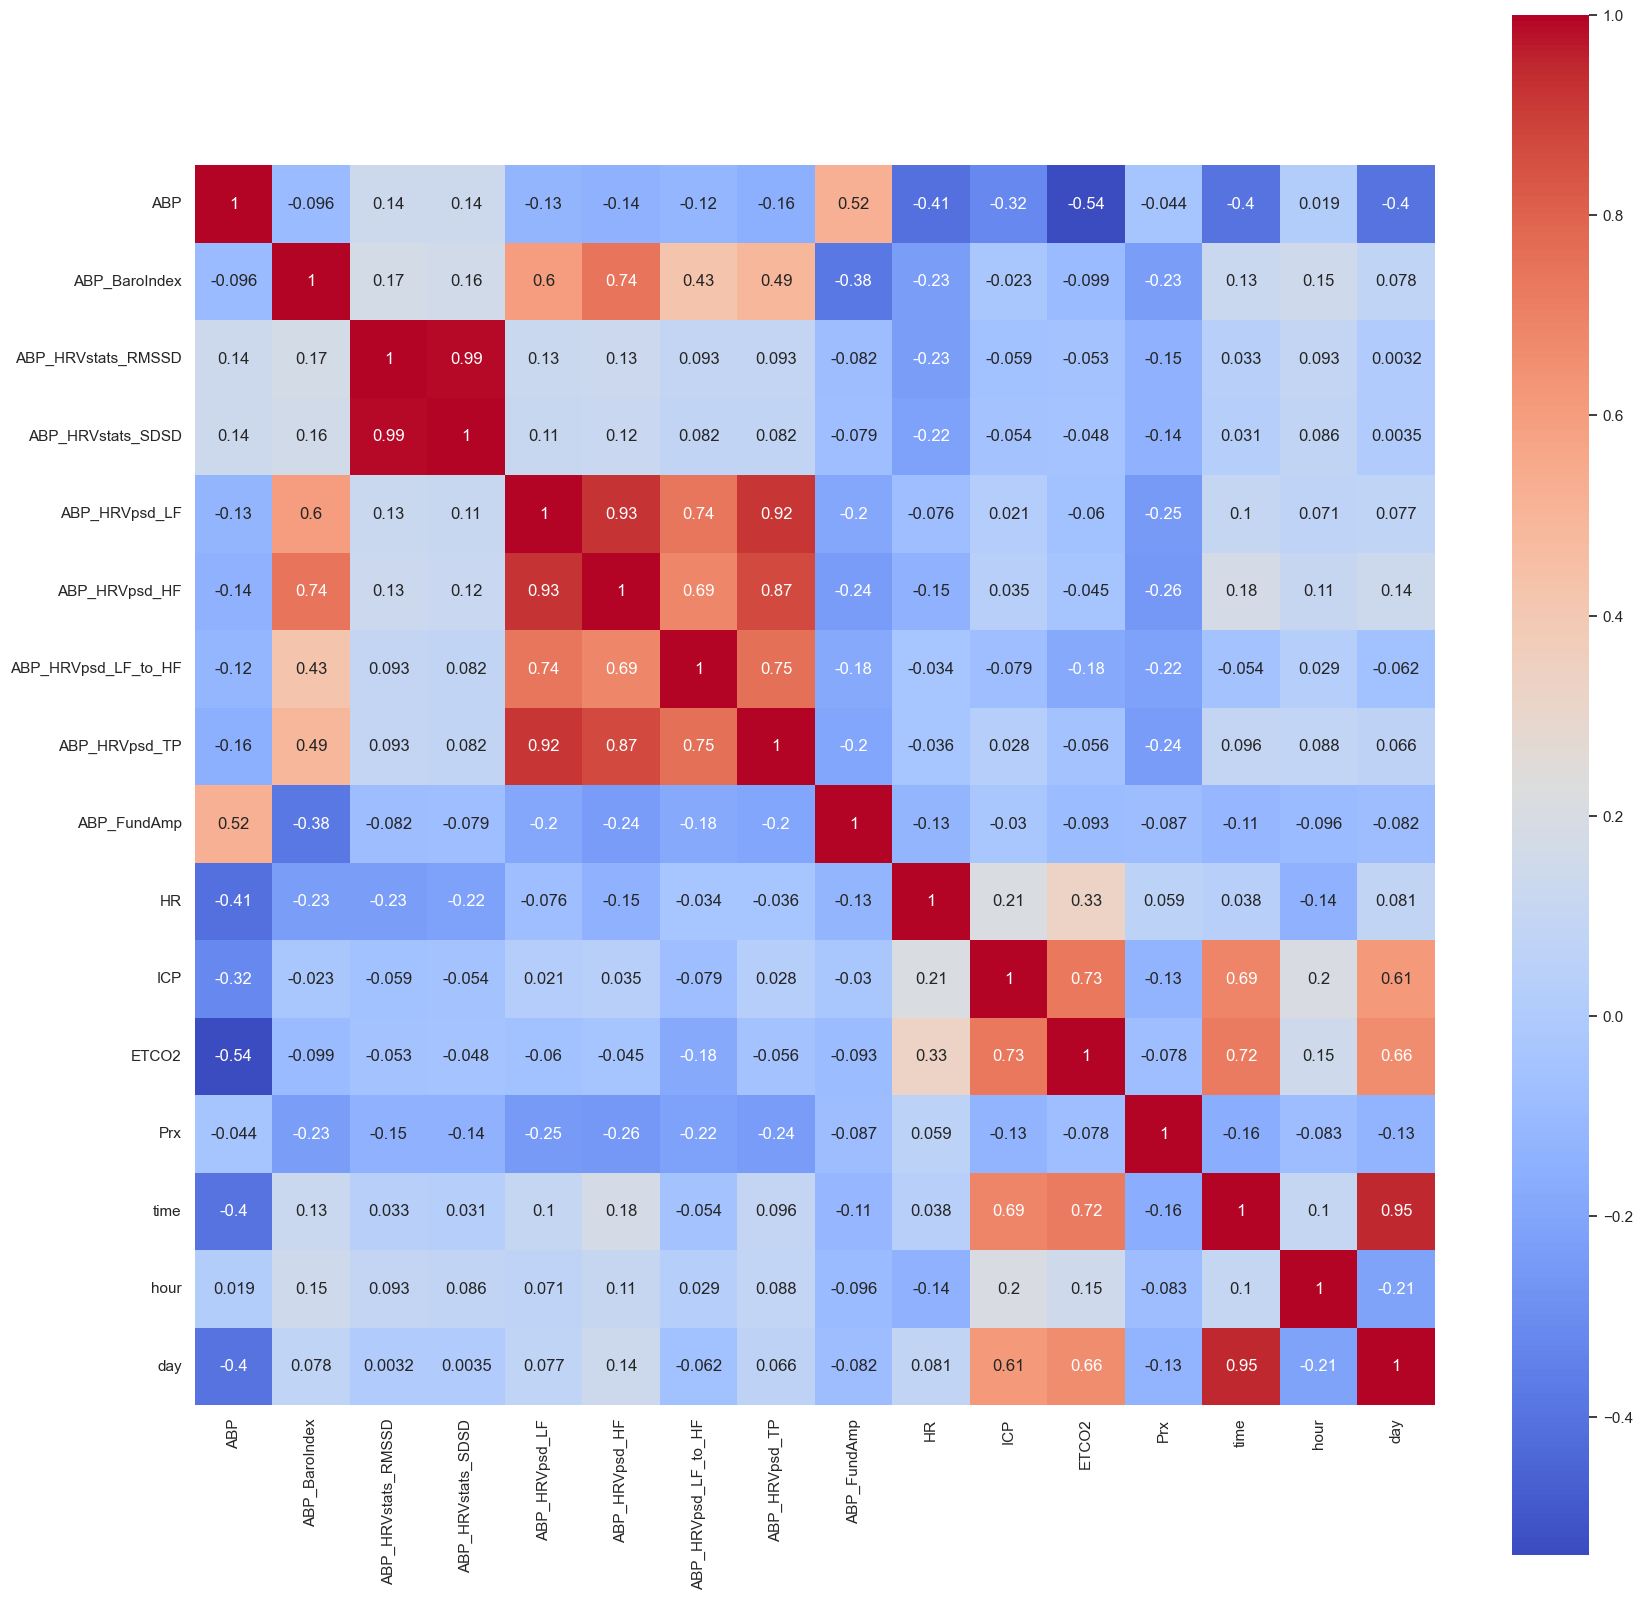

 33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]

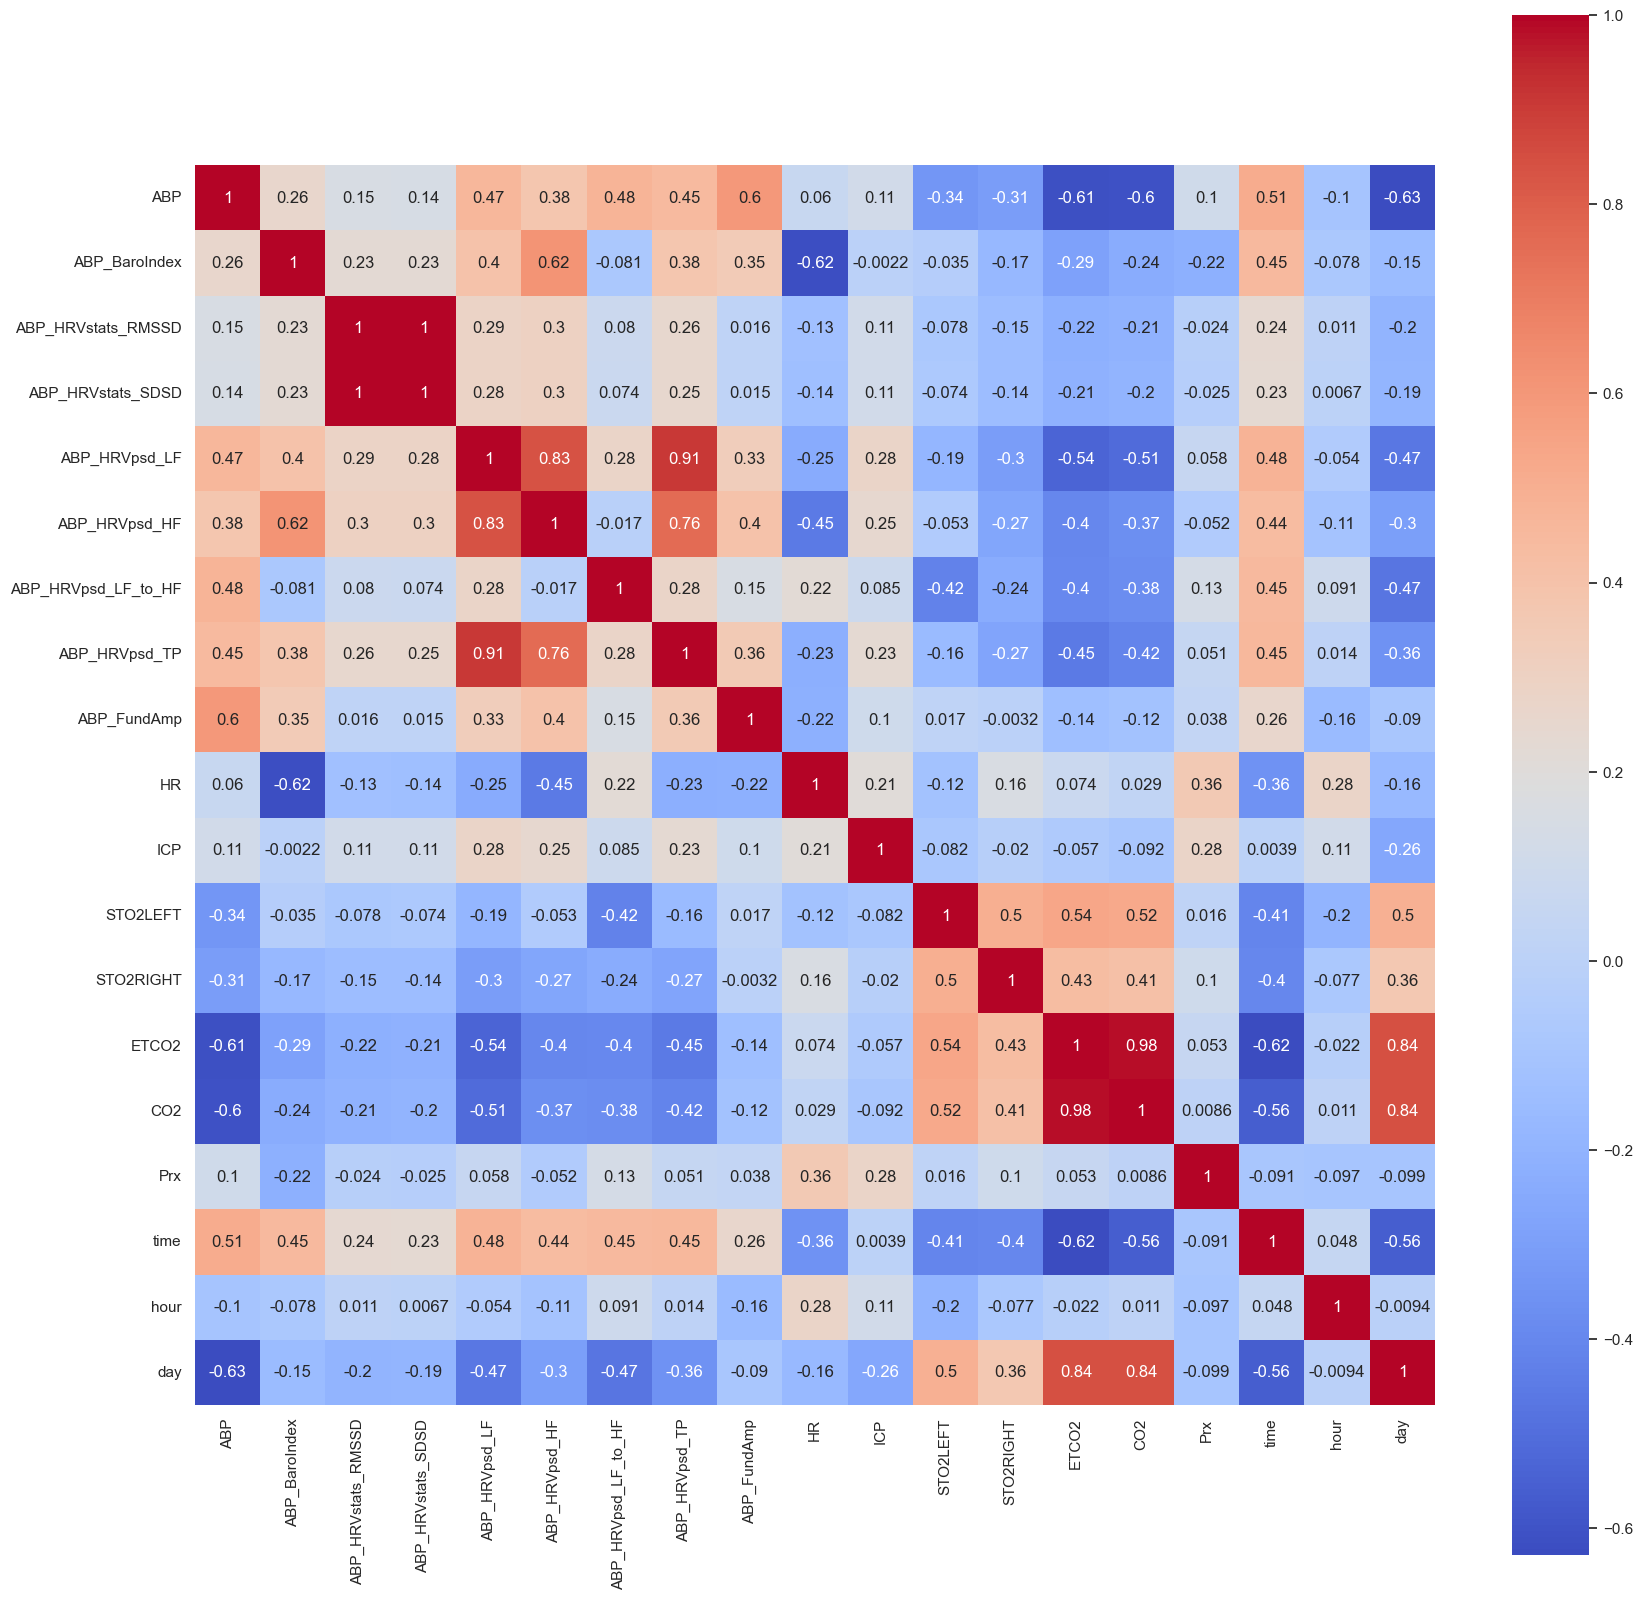

 67%|██████▋   | 2/3 [00:01<00:00,  1.09it/s]

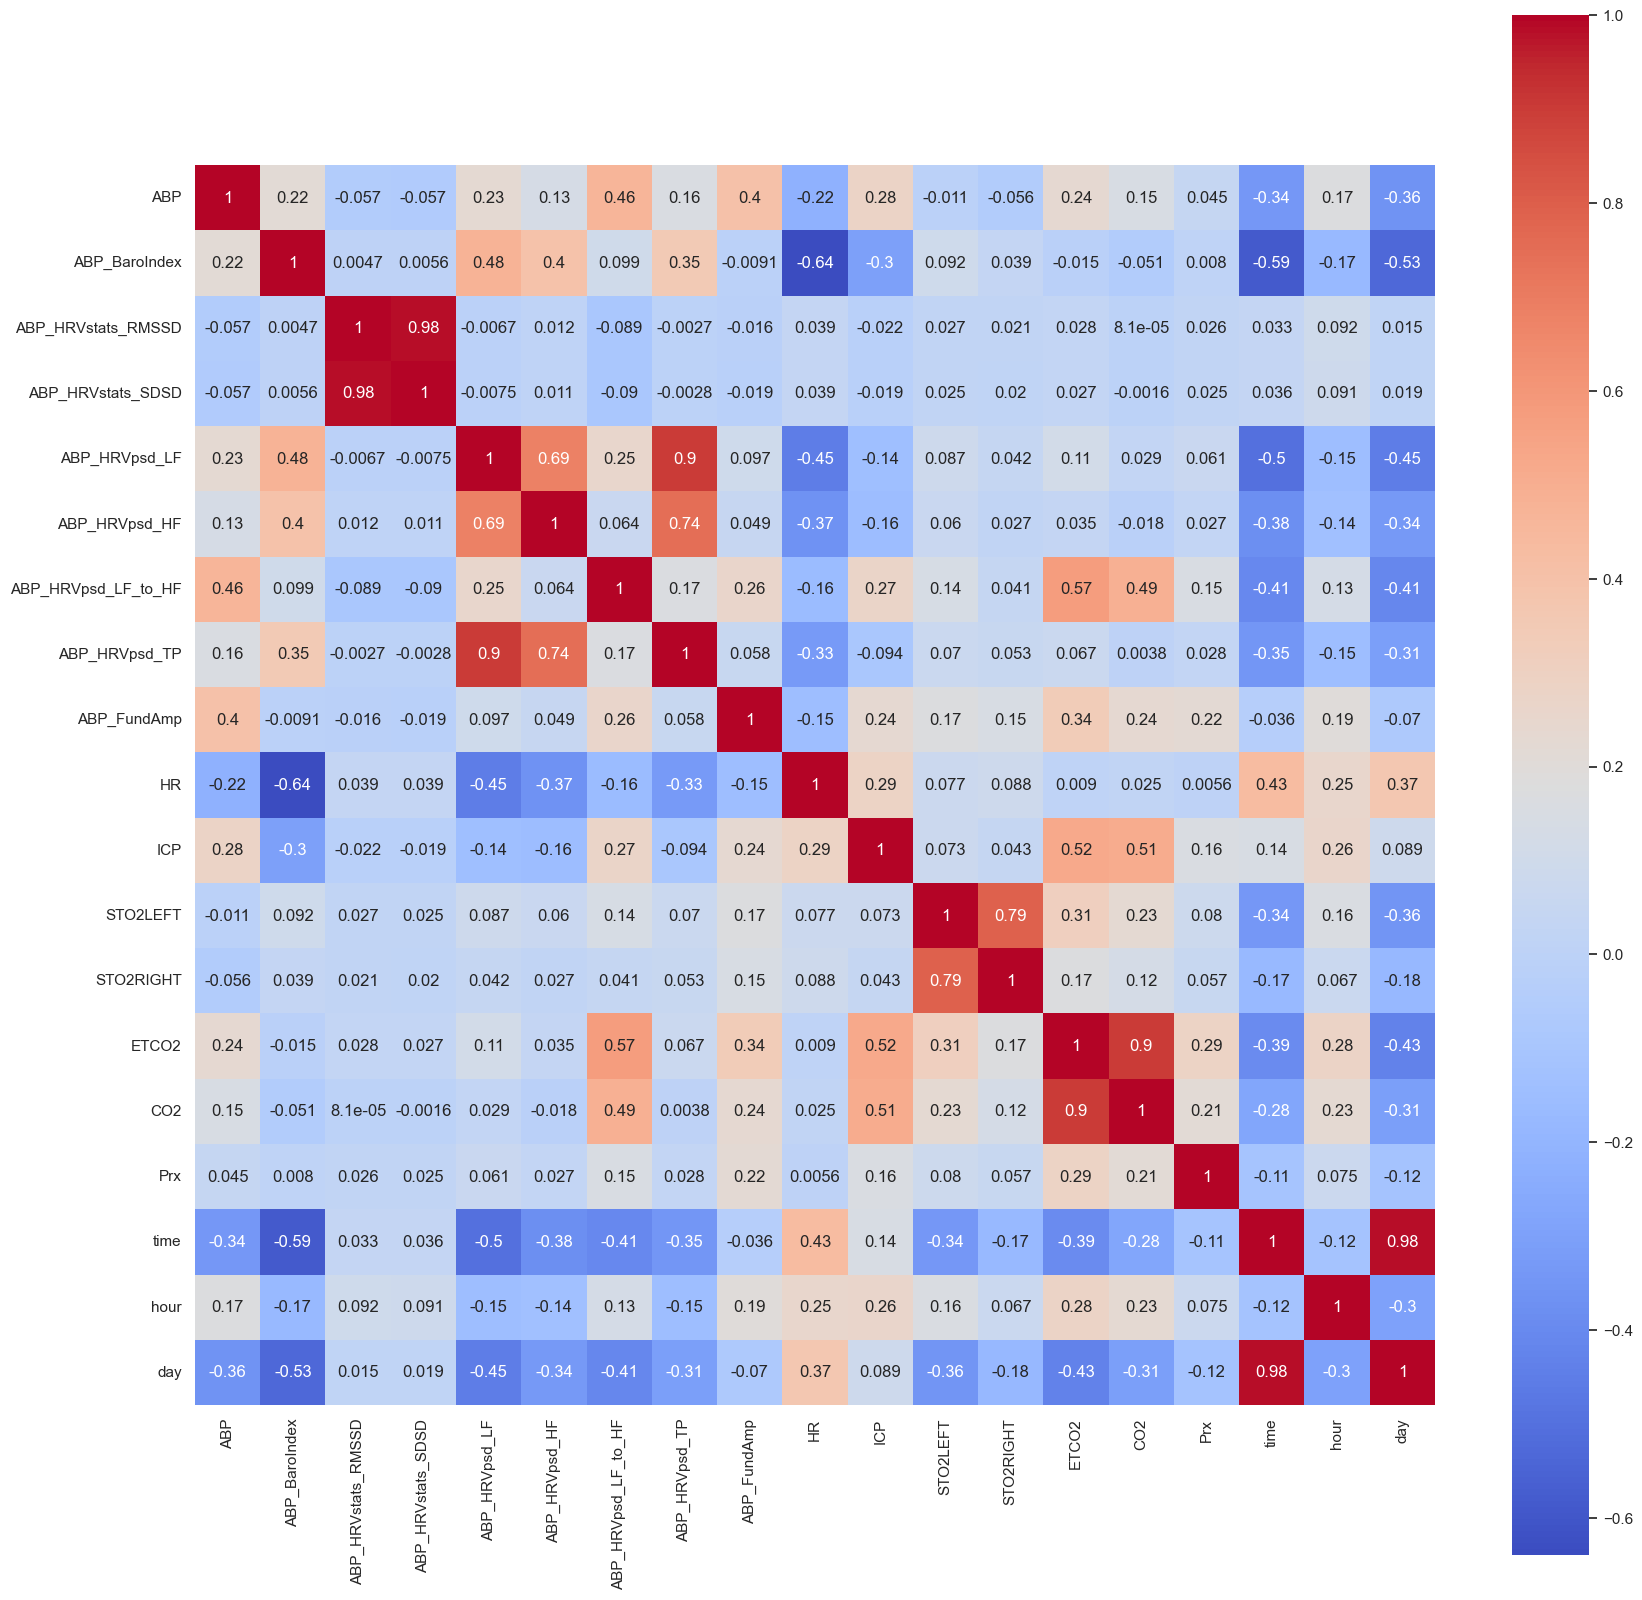

100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


In [477]:
corr_values = []
for key, df in tqdm(data_frames.items()):
    data_frames[key] = df.dropna()
    plt.figure(figsize=(20, 20)) 
    corr = data_frames[key].corr()
    corr_values.append(corr_melt(corr))
    sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
    plt.show()

### Correlation between patients

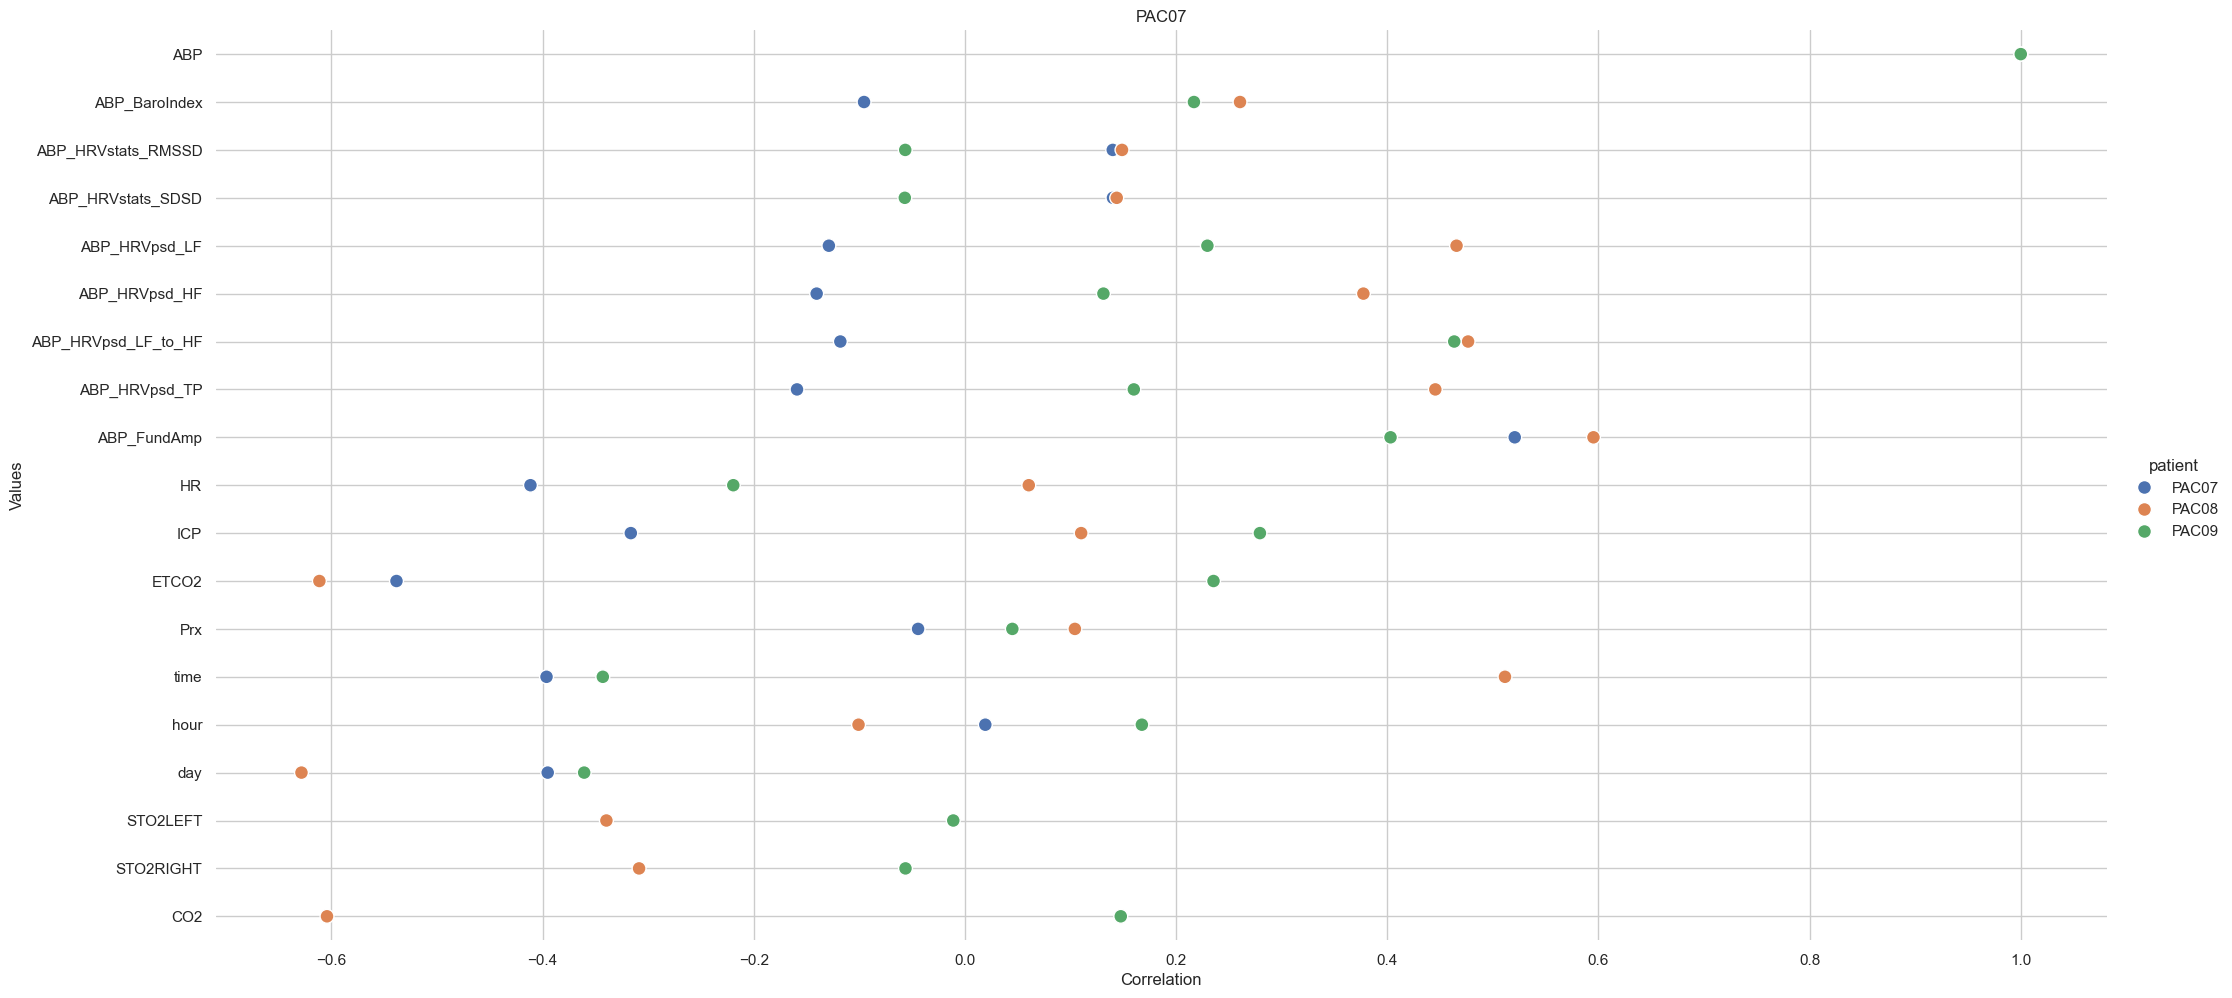

In [478]:
corr_values_df = pd.concat(corr_values)
sns.set_theme(style="whitegrid")
g = sns.PairGrid(corr_values_df, y_vars='value', x_vars='ABP', hue='patient', height=10, aspect=2) 
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")
g.set( xlabel='Correlation', ylabel='Values')
g.add_legend()
for ax, title in zip(g.axes.flat, data_frames.keys()):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)
plt.show()   

Based on this preliminary analysis, we can conclude that `ABP_Fund_Amp` exhibits  strongest and most stable correlation with ABP recordings.

### Data Seasonality

In [479]:
from statsmodels.tsa.seasonal import seasonal_decompose

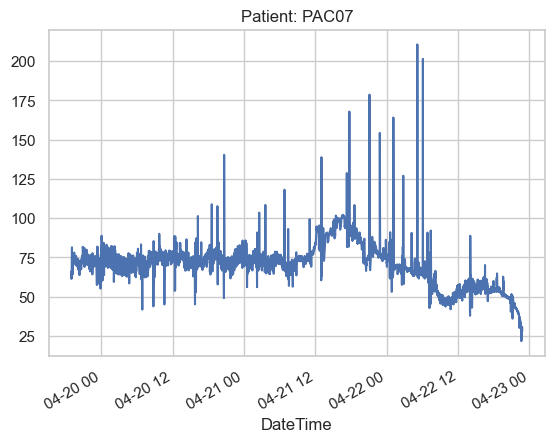

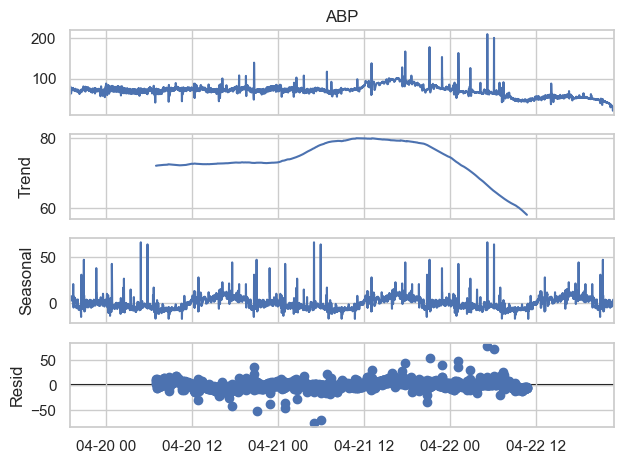

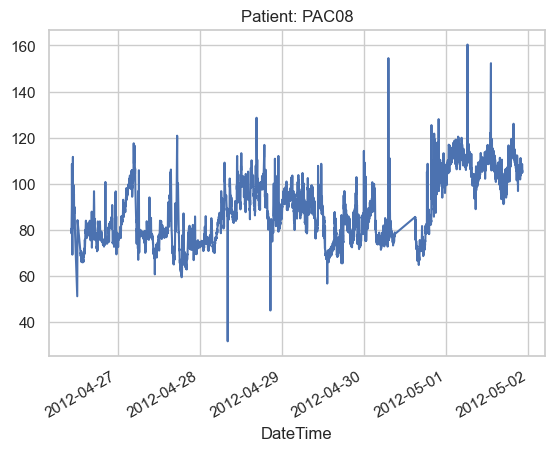

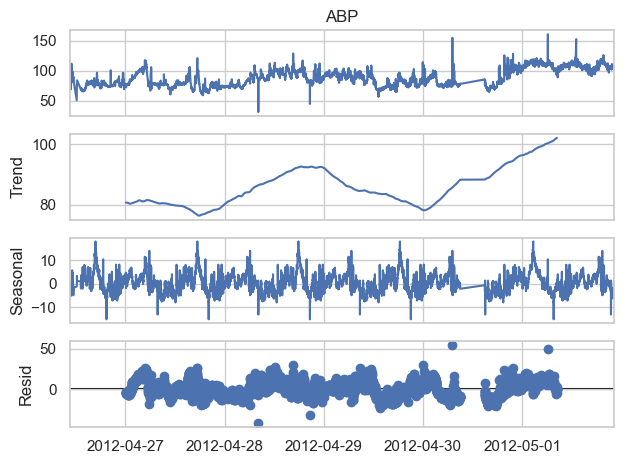

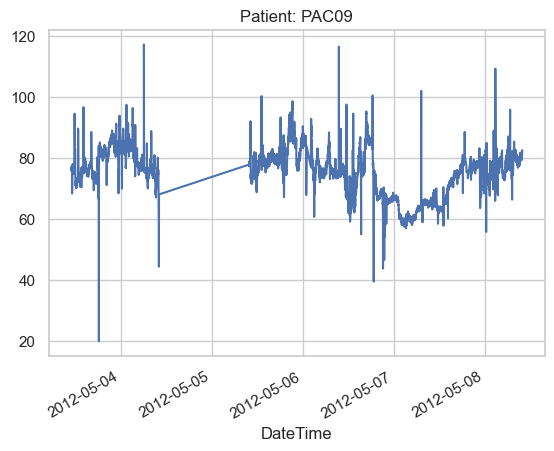

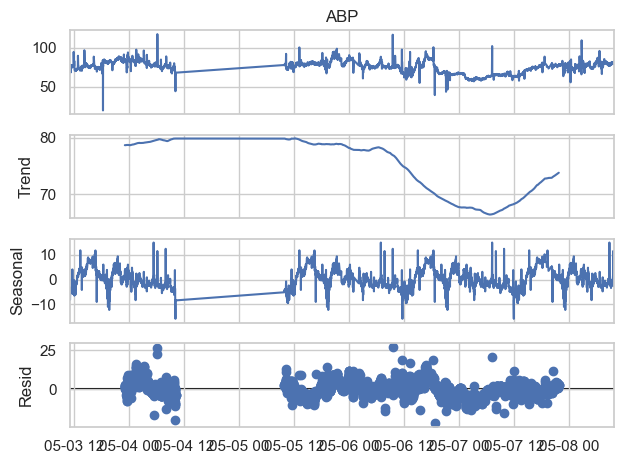

In [507]:
for patient in data_frames.keys():
    data_frames[patient]['ABP'].plot(title=f"Patient: {patient}")
    plt.show()
    result = seasonal_decompose(data_frames[patient]['ABP'], period=1440, model='additive')
    result.plot()
    plt.show()

## Autocorrelation

In [509]:
for patient in data_frames.keys():
  acf_values = acf(data_frames[patient]['ABP'], nlags=20)
  q_values, p_values = q_stat(acf_values[1:], len(data_frames[patient]['ABP']))
  print('P-values from Ljung-Box Test:', p_values)
  

P-values from Ljung-Box Test: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
P-values from Ljung-Box Test: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
P-values from Ljung-Box Test: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Autocorrelation does not appear in this data 

## Additional descriptors 

Before any actual calculations we need to manage Artifacts, we would use interpolation to change them into more reliable data 

First hovever Sampling frequency need to be accessed

In [502]:
for patient in data_frames.keys():
  data_frames[patient].reset_index(inplace=True)
  
  time_diffs = data_frames[patient]['time'].diff().dropna()
  time_diffs_in_seconds = time_diffs.dt.total_seconds()
  
  time_diffs_in_seconds.to_csv(patient + 'time_diffs_in_seconds.csv', index=False)
  
  average_sampling_interval = time_diffs_in_seconds.mean()
  std_sampling_interval = time_diffs_in_seconds.std()
  sampling_frequency = 1 / average_sampling_interval
  
  print(f"Average Sampling Interval: {average_sampling_interval} seconds")
  print(f"Standard Deviation of Sampling Interval: {std_sampling_interval} seconds")
  print(f"Sampling Frequency: {sampling_frequency} Hz")
  
  data_frames[patient]['SAMPLING_FREQUENCY'] = average_sampling_interval
  
  data_frames[patient].set_index('DateTime', inplace=True)

Average Sampling Interval: 60.34475138121547 seconds
Standard Deviation of Sampling Interval: 6.298326652521449 seconds
Sampling Frequency: 0.016571449498278767 Hz
Average Sampling Interval: 68.18195111430626 seconds
Standard Deviation of Sampling Interval: 260.7654528894756 seconds
Sampling Frequency: 0.014666638071467205 Hz
Average Sampling Interval: 78.1505681402996 seconds
Standard Deviation of Sampling Interval: 1154.981450870684 seconds
Sampling Frequency: 0.012795812286415534 Hz


C:\Users\damia\AppData\Local\Temp\ipykernel_10884\3412745904.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frames[patient]['SAMPLING_FREQUENCY'] = average_sampling_interval


In [500]:
for patient in data_frames.keys():
  sampling_rate_sec = data_frames[patient]['SAMPLING_FREQUENCY'].mean()
  sampling_rate_hz = 1 / sampling_rate_sec
  print(f"Patient: {sampling_rate_hz}")
  nk.ppg_process(ppg_signal=data_frames[patient]['ABP'], sampling_rate=sampling_rate_hz)

Patient: 0.01657144949827877


ValueError: Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=0.01657144949827877 -> fs/2=0.008285724749139385)

`Fund_Amp` is frequency domain parameter wchich exhibits highest correlation with given patients. We can combine data to hour long samples and then calculate other frequency domain parameters

As we can see something might be wrong with the data - this need to be checked

In [484]:
windows_from_all_patients = {}
for patient in tqdm(data_frames.keys()):
    sampling_frequency = data_frames[patient]['SAMPLING_FREQUENCY'].mean() # Better startego for storing required 
    all_windows = create_windows(data_frames[patient], 60, sampling_frequency)
    windows_from_all_patients[patient] = all_windows
    print(f"Number of windows: {len(all_windows)}")

  0%|          | 0/3 [00:00<?, ?it/s]

Window size in samples: 59
Number of windows: 77
Window size in samples: 52


100%|██████████| 3/3 [00:00<00:00,  5.95it/s]

Number of windows: 134
Window size in samples: 46
Number of windows: 120


In [483]:
def create_windows(df, window_size_in_minutes, sampling_frequency_in_seconds):
    """
    This function creates windows of the given size from the data.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the data.
    window_size_in_minutes : int
        The size of the window in minutes.
    sampling_frequency : float
        The sampling frequency of the data.
    
    Returns
    -------
    windows : pandas.DataFrame
        The windows of the given size.
    """
    windows = []
    window_size_in_seconds = window_size_in_minutes * 60
    
    window_size_in_samples = window_size_in_seconds / sampling_frequency_in_seconds
    window_size_in_samples = np.floor(window_size_in_samples).astype(int)
    print(f"Window size in samples: {window_size_in_samples}")
    for i in range(0, len(df), window_size_in_samples):
        window = df.iloc[i:i + window_size_in_samples]
        windows.append(window)
    
    return windows  # return only the first window

  0%|          | 0/3 [00:00<?, ?it/s]

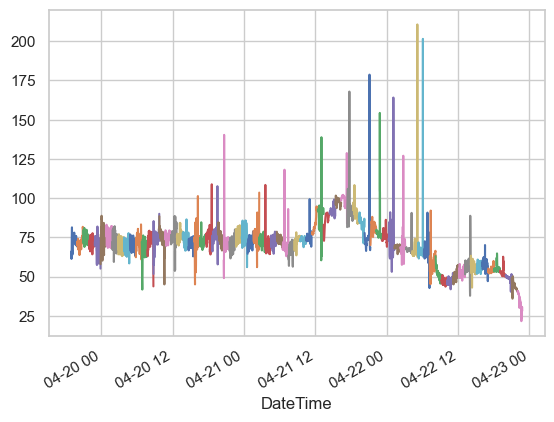

 33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]

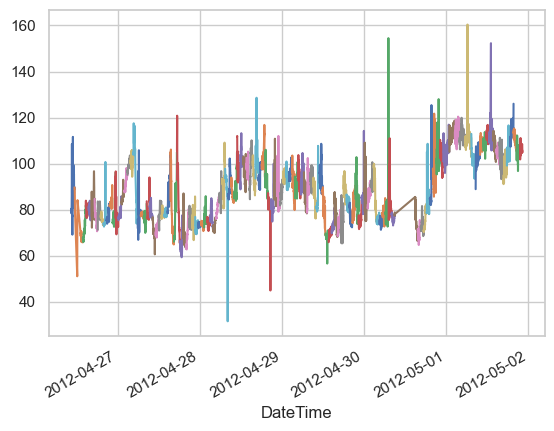

 67%|██████▋   | 2/3 [00:03<00:01,  1.71s/it]

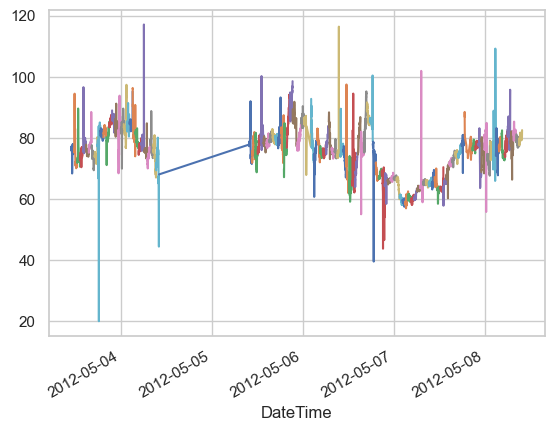

100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


In [485]:
for patient in tqdm(data_frames.keys()):
    windows = windows_from_all_patients[patient]
    for window in windows:
        window['ABP'].plot()
    plt.show()
  